In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, zscore, multivariate_normal
from scipy.spatial.distance import cdist
import math
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import transmorph as tr

DATA_PATH = 'datasets/snare-seq/'

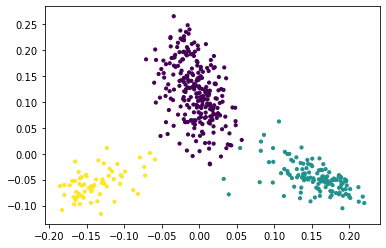

In [2]:
# Chromatin data
df_c = pd.read_csv(DATA_PATH + 'cell_topics.tsv', delimiter='\t').T
df_c["cluster"] = np.loadtxt(DATA_PATH + 'chr_labels.tsv', delimiter='\t').astype(int)
X_c = df_c.to_numpy()[:,:-1]
pca_c = PCA(n_components=19)
X_c = pca_c.fit_transform(X_c)
#knn_graph_c = kneighbors_graph(X_c, n_neighbors=5)

c_t = df_c["cluster"]

# Random unbalancing
keep_p = np.array([0.8, 0.4, 0.2])
random_p = np.random.uniform(0, 1, size=(len(X_c),))
sel_p = keep_p[c_t]
selector = random_p < sel_p
Xu_c = X_c[selector,:]
cu_t = c_t[selector]
cell_names_chr = df_c.loc[selector].index

# PCA
pca = PCA(n_components=3)
X_c_pca = pca.fit_transform(X_c)
Xu_c_pca = X_c_pca[selector]
plt.scatter(*Xu_c_pca[:,:2].T, s=10, c=cu_t)

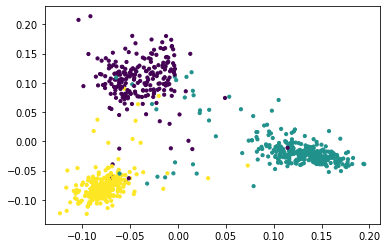

In [3]:
# RNA-seq data
adata_r = sc.read_text(DATA_PATH + 'GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv', delimiter='\t').T
adata_r.obs["cluster"] = np.loadtxt(DATA_PATH + 'rna_labels.tsv', delimiter='\t').astype(int)
sc.pp.normalize_per_cell(adata_r, 1)
sc.pp.log1p(adata_r)
sc.pp.highly_variable_genes(adata_r, n_top_genes=1000)
X_r = zscore(adata_r.X) / 100
pca_r = PCA(n_components=19)
X_r = pca_r.fit_transform(X_r)
c_s = adata_r.obs["cluster"]

keep_p = np.array([0.7, 1, 0.8])
random_p = np.random.uniform(0, 1, size=(len(X_r),))
sel_p = keep_p[adata_r.obs["cluster"]]

# PCA
pca_r2 = PCA(n_components=3)
X_r_pca = pca_r2.fit_transform(X_r)

# Removing outliers
sel = np.abs(X_r_pca.max(axis=1)) < 0.25
X_r = X_r[sel]
X_r_pca = X_r_pca[sel]
c_s = c_s[sel]

# Creating unbalanced dataset
selector = (random_p < sel_p)[sel]
Xu_r_pca = X_r_pca[selector]
Xu_r = X_r[selector,:]
cu_s = c_s[selector]
cell_names_rna = adata_r.obs_names[sel][selector]

# Plot
plt.scatter(*Xu_r_pca[:,:2].T, s=10, c=cu_s)

In [4]:
xs, yt = X_r, X_c
xsu, ytu = Xu_r, Xu_c

common_cells = cell_names_chr.intersection(cell_names_rna) # Still coupled cells

print("%i common cells" % len(common_cells))

commonc_indices_chr = [cell_names_chr.get_loc(c) for c in common_cells]
commonc_indices_rna = [cell_names_rna.get_loc(c) for c in common_cells]

352 common cells


# Optimal transport

In [16]:
w_weighted = tr.Transmorph(method='ot', scale=8e-1)
w_unweighted = tr.Transmorph(method='ot', weighted=False)

# Unbalanced data
print('Classic GW-u')
xtu_nodens = w_unweighted.fit_transform(xsu, ytu)
print('Corrected GW-u')
xtu = w_weighted.fit_transform(xsu, ytu)

Xu_cr_pca = pca.transform(xtu)
Xu_cr_pca_nd = pca.transform(xtu_nodens)
oneovern = np.array([1.0/len(xs)]*len(xs))

Transmorph > Successfully initialized.
(Transmorph) ot based -- max_iter: 1000000 -- no entropy -- weighted, alpha_qp: 1.000000, scale: 0.800000
Transmorph > Successfully initialized.
(Transmorph) ot based -- max_iter: 1000000 -- no entropy -- unweighted
Classic GW-u
Transmorph > Computing optimal transport plan...
WOTi > Computing optimal transport plan...
Transmorph > Transmorph fitted.
Transmorph > Projecting dataset...
Corrected GW-u
Transmorph > Computing source distribution weights...
Transmorph > Computing reference distribution weights...
Transmorph > Computing optimal transport plan...
WOTi > Computing optimal transport plan...
Transmorph > Transmorph fitted.
Transmorph > Projecting dataset...


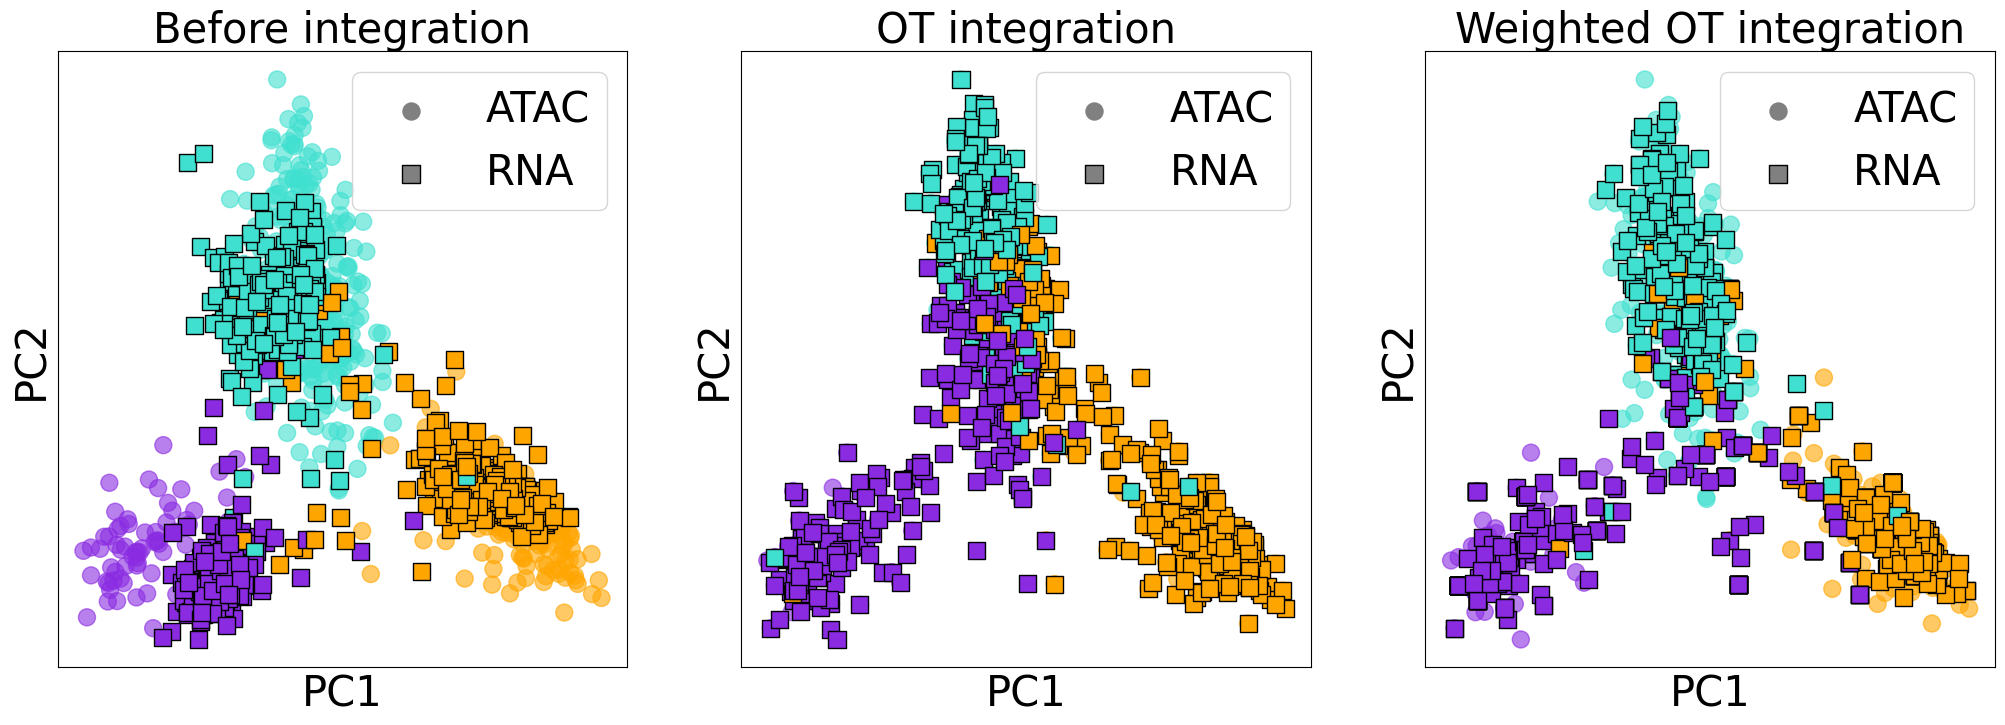

In [17]:
# Optimal transport

colors = np.array(["turquoise", "orange", "blueviolet"])
c_s_col = colors[c_s]
c_t_col = colors[c_t]
cu_s_col = colors[cu_s]
cu_t_col = colors[cu_t]

plt.style.use('default')

plt.figure(figsize=(25,8))

plt.subplot(1,3,1)
plt.scatter(*Xu_c_pca[:,:2].T, s=150, c=cu_t_col, alpha=0.6)
plt.scatter(*Xu_r_pca[:,:2].T, s=150, c=cu_s_col, cmap='viridis', ec='k', marker='s')
plt.scatter([], [], c='gray', s=150, label='ATAC')
plt.scatter([], [], c='gray', s=150, marker='s', label='RNA', ec='k')
plt.xlabel("PC1", fontsize=30)
plt.ylabel("PC2", fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=30)
plt.title('Before integration', fontsize=30)

plt.subplot(1,3,2)
plt.scatter(*Xu_c_pca[:,:2].T, s=150, c=cu_t_col, alpha=0.6)
plt.scatter(*Xu_cr_pca_nd[:,:2].T, s=150, c=cu_s_col, cmap='viridis', ec='k', marker='s')
plt.scatter([], [], c='gray', s=150, label='ATAC')
plt.scatter([], [], c='gray', s=150, marker='s', label='RNA', ec='k')
plt.xlabel("PC1", fontsize=30)
plt.ylabel("PC2", fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=30)
plt.title('OT integration', fontsize=30)

plt.subplot(1,3,3)
plt.scatter(*Xu_c_pca[:,:2].T, s=150, c=cu_t_col, alpha=0.6)
plt.scatter(*Xu_cr_pca[:,:2].T, s=150, c=cu_s_col, cmap='viridis', ec='k', marker='s')
plt.scatter([], [], c='gray', s=150, label='ATAC')
plt.scatter([], [], c='gray', s=150, marker='s', label='RNA', ec='k')
plt.xlabel("PC1", fontsize=30)
plt.ylabel("PC2", fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=30)
plt.title('Weighted OT integration', fontsize=30)

pass